In [1]:
from typing import Any
import random
import os

import numpy as np

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from validation_model import ValidationModel
from settings import *
from avapix.avapix_loss import AvapixLoss
from avapix.avapix_model import AvapixModel
import avapix.avapix_utils as utils

In [2]:
DEVICE = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)

print (f'Using device: {DEVICE}')

Using device: cuda


In [146]:
class EmbeddedFacesDataset(Dataset):
    def __init__(self, num_samples) -> None:
        super().__init__()

        self.transform = ToTensor()

        self.num_samples = num_samples
        self.random_lengths = list(range(128))

    def __getitem__(self, index) -> Any:
        curr_rand_len = random.choice(self.random_lengths)

        curr_image_tensor = np.random.randint(0, 256, (8, 8, 3))
        curr_image_tensor = torch.tensor(curr_image_tensor, device=DEVICE, dtype=torch.float)
        output_img = utils.generate_input_v1(curr_image_tensor,
                                             DEFAULT_RANDOM_SEED,
                                             curr_rand_len)
        output_img = output_img.reshape((8, 8, 3)).permute((2, 0, 1))

        return output_img / 255

    def __len__(self):
        return self.num_samples


In [215]:
import importlib
import avapix.avapix_model
import avapix.avapix_loss
import avapix.avapix_utils
importlib.reload(avapix.avapix_model)
importlib.reload(avapix.avapix_loss)
importlib.reload(avapix.avapix_utils)
from avapix.avapix_model import AvapixModel
from avapix.avapix_loss import AvapixLoss
import avapix.avapix_utils as utils

In [155]:
LEARNING_RATE = 0.00005
BATCH_SIZE = 16
NUM_EPOCHS = 15

image_list = os.listdir(VALID_FACE_DIR)
image_list = [os.path.join(VALID_FACE_DIR, img_file) for img_file in image_list]

dataset = EmbeddedFacesDataset(50_000)
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=False)

model = AvapixModel()

criterion = AvapixLoss(0.000001)

loss_model = ValidationModel()
loss_model.load_state_dict(torch.load('./assets/validation_model.pth'))

optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE,
                             weight_decay=1e-4)

In [156]:
losses = []

_ = 0
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0

    for batch_imgs in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_imgs)

        face_loss = loss_model(outputs)
        loss = criterion(face_loss, batch_imgs, outputs)

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    # for i, tensor_img in enumerate(outputs):
    #     img = img_tensor_to_numpy(tensor_img) * 255
    #     img = img.astype(np.uint8)
    #     Image.fromarray(img).save(f'./train_outputs/{_}_{i}.png')
    # _ += 1

    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)

    print(f"Epoch {epoch+1:03d}/{NUM_EPOCHS} - Loss: {avg_loss:.4f}")
    # if epoch % 10 == 9:
    #     print(f"Epoch {epoch+1:03d}/{NUM_EPOCHS} - Loss: {avg_loss:.4f}", end='\t')
    #     if (epoch + 1) % 20 == 0:
    #         print()

print("Training complete.")

Epoch 001/15 - Loss: 7.8098
Epoch 002/15 - Loss: 4.0664
Epoch 003/15 - Loss: 3.4634
Epoch 004/15 - Loss: 3.1719
Epoch 005/15 - Loss: 2.9691
Epoch 006/15 - Loss: 2.8602
Epoch 007/15 - Loss: 2.8128
Epoch 008/15 - Loss: 2.7981
Epoch 009/15 - Loss: 2.7920
Epoch 010/15 - Loss: 2.7890
Epoch 011/15 - Loss: 2.7873
Epoch 012/15 - Loss: 2.7863
Epoch 013/15 - Loss: 2.7856
Epoch 014/15 - Loss: 2.7853
Epoch 015/15 - Loss: 2.7850
Training complete.


## Test Area
---

In [344]:
import importlib
import avapix.avapix_model
import avapix.avapix_loss
import avapix.avapix_utils
import validation_model
importlib.reload(avapix.avapix_model)
importlib.reload(avapix.avapix_loss)
importlib.reload(avapix.avapix_utils)
importlib.reload(validation_model)
from avapix.avapix_model import AvapixModel
from avapix.avapix_loss import AvapixLoss
import avapix.avapix_utils as utils
from validation_model import ValidationModel

LEARNING_RATE = 0.0001
BATCH_SIZE = 32
NUM_EPOCHS = 100
GEN_PER_IMAGE = 10

image_list = os.listdir(VALID_FACE_DIR)
image_list = [os.path.join(VALID_FACE_DIR, img_file) for img_file in image_list]

dataset = EmbeddedFacesDataset(100000)
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=False)

model = AvapixModel()

criterion = AvapixLoss()

loss_model = ValidationModel()
loss_model.load_state_dict(torch.load('./assets/validation_model.pth'))

optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE,
                             weight_decay=1e-4)

for batch_imgs in dataloader:
    outputs = model(batch_imgs)
    break

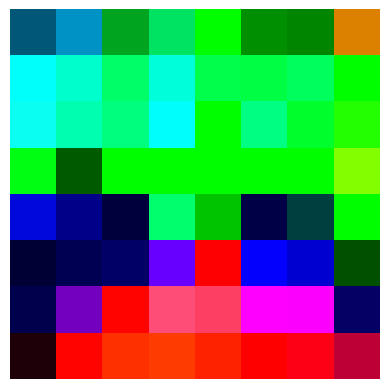

In [157]:
utils.show_model_output_image(outputs[15])

---

In [211]:
_ = utils.embed_raw_img_v1('bc1qxy2kgdygjrsqtzq2n0yrf2493p83kkfjhx0wlh', 42).to(DEVICE) / 255
_ = _.reshape((8, 8, 3)).permute((2, 0, 1))
_ = _.unsqueeze(0)

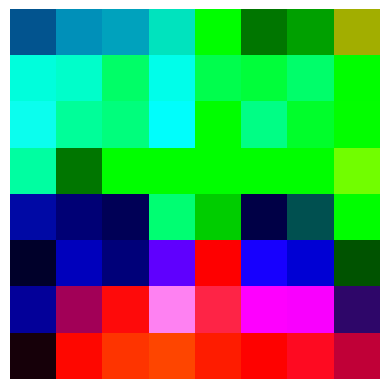

In [217]:
i_ = model(_)
utils.show_model_output_image(i_)

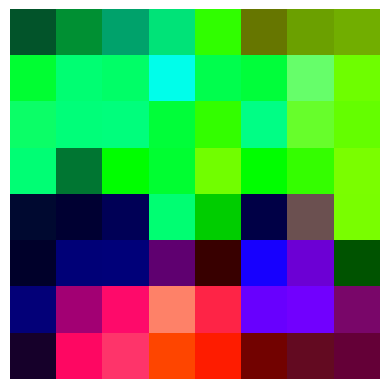

In [218]:
mask = _ != 0
i_[mask] = _[mask]

utils.show_model_output_image(i_)

In [219]:
utils.extract_text(i_)

'bc1qxy2kgdygjrsqtzq2n0yrf2493p83kkfjhx0wlh'

---

In [144]:
import torch

t1 = torch.ones(5, 3, 8, 8)
t2 = torch.zeros(5, 3, 8, 8)

mask = t1 > 0.5
result = torch.zeros_like(t2)
result[mask] = t2[mask]

(result - t1).abs().sum()

tensor(960.)